# Part 4: iwaspoisoned.com

### Context

One of the datasources we thought would be relevant to assessing the health aspect of quality of restaurants in districts in San Francisco is [iwaspoisoned.com](https://www.iwaspoisoned.com). Iwaspoisoned.com is a consumer led website for diners to report suspected food poisoning or bad food experiences. The website collects and screens reports of foodborne illness across the United States and the world, and shares that information with public health departments and industry. 

The intention behind examining these health reports was to see from which district the most number of negative health experiences were reported. Rather than considering the number of reports on a restaurant-level, we would aggregate all the data of any restaurant in a given district. This could help us compare the general quality of restaurants in each district, specifically the health aspect in this case. 

### Methodology

The metric to compare the different San Francisco districts using the website is the number of reports of restaurants in each district. The content or description of the health report is not important to us since we know the sentiment will be negative if it is reported on the site. This is in contrast to yelp reviews where the content of the review is helpful to our analysis since it can be positive or negative. In the case of iwaspoisoned.com, users only report negative health experiences to the website so an analysis of the content will not produce any significant results. As a result, we are only considering the total number of reports per district to determine the quality of restaurants in each area.

Since each report includes the address of the restaurant being reported, the way this data collection was possible was by scraping the website to get the total number of reports of restaurants by zipcode and then aggregating the data by district. We created a list of zip codes of all the neighborhood in San Francisco. We then had to divide the zipcodes according to the 10 main districts we defined according to the popular sources we researched. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp # other science tools
import seaborn as sns

%matplotlib inline

# Web scraping tools
import lxml.html as lx
import requests
import requests_cache

requests_cache.install_cache("../iwaspoisoned")

The layout of the website was such that not all the reports contained the full address of the restaurant on the homepage. While location is part of the report preview as the restaurant name is required, not all of them listed the zipcodes of the restaurant. We realized that most reports listed the complete addresses, including the zipcode, once you click on the report link individually and redirected to the report-specific page. As a result, we first created a function to get all the links of each report from the home page so they can be queried individually.

In [2]:
def get_links(url, page):
    """
    Function to get links of each individual report on page.
    Input: page (int) - page to scrape for links
           url (string) - url to scrape for links
    Output: links (list) - list of links
    """
    
    # scrape url with page parameter
    response = requests.get(url, params = {
        "page": page
    })
    try:
        response.raise_for_status()
    except:
        print("The url couldn't be downloaded.\n")
    html = lx.fromstring(response.text)
    html.make_links_absolute(url)
    
    # scrape main content section of page
    reports = html.xpath("//div[contains(@class, 'textReports')]/text()")[0]
    reports = reports.strip()
    
    # check to see if end of results has been reached
    if reports == 'No incidents':
        return
    
    # if there are reports on the page, get list of links
    links = html.xpath("//section[contains(@class,'page-content')]//div[contains(@class,'col-md-6 report-first-box')]/a//@href")
    return links

Once we were able to scrape each report individually, we extracted the zipcode from the address of the restaurant reported.

In [3]:
def get_zipcode(url):
    """
    Function to get zipcode from restaurant address of report.
    Input: url (string) - url to scrape for zipcode
    Output: zipcode (string) - zipcode of restaurant reported
    """
    
    response = requests.get(url)
    response.text
    try:
        response.raise_for_status()
    except:
        print("The url couldn't be downloaded.\n")
    html = lx.fromstring(response.text)
    html.make_links_absolute(url)
    
    # scrape address line from report
    links = html.xpath("//span[contains(@class,'pl-1 py-0 text-muted')]/text()")[0]
    
    # get zipcode from address
    zipcode = links.split('\n')[3].strip()
    return zipcode

The exact url we scraped included the location of reports set to San Francisco, so the complete url was "https://iwaspoisoned.com/location/united-states/california/san-francisco". This way, we would not have to filter through the zipcodes returned to choose the relevant ones in a San Francisco district. The main part of the web scraping takes place in a loop to go through all the pages of reports. Since there was no way to scrape the total number of pages of reports, we realized that when the end of the reports was reached, the website displays "No incidents". So we added a check to our function that gets the report links to see if this string was returned. If it is, then the function returns an empty list and in our main function we maintain a while loop which continues while the list returned is not empty. 

In order to keep track of the number of reports per zipcode, we create and populate a dictionary where the keys are the zipcodes and the values are the counts of reports for restaurants in that zipcode. 

In [4]:
def compute_freqs(url):
    """
    Function to compute counts of reports of restaurants by zipcode.
    Input: url (string) - url to scrape for links
    Output: zipcode_dict (dict) - dictionary with keys as zipcodes and keys as count of reports
    """
    
    i = 1
    
    # get list of report links
    links = get_links(url, i)
    zipcode_dict = dict()
    
    # loop through pages of reports until list of report links returned is empty
    while links != None:
        
        # iterate through each report
        for link in links:
            zipcode = get_zipcode(link)
            if zipcode == "":
                continue

            # if zipcode is already in dictionary, increment count
            if zipcode in zipcode_dict.keys():
                zipcode_dict[zipcode] += 1
                
            # else add zipcode to dictionary with count of 1
            else:
                zipcode_dict[zipcode] = 1
        
        i += 1
        links = get_links(url, i)
    return zipcode_dict

# url with location set to San Francisco
url = "https://iwaspoisoned.com/location/united-states/california/san-francisco"
dictionary = compute_freqs(url)
dictionary
        

{'94109': 49,
 '94107': 29,
 '94121': 43,
 '94104': 13,
 '94111': 37,
 '94132': 22,
 '94118': 55,
 '94105': 29,
 '94115': 22,
 '94124': 24,
 '94102': 38,
 '94108': 21,
 '94133': 32,
 '94112': 22,
 '94117': 11,
 '94103': 62,
 '94110': 29,
 '94134': 7,
 '94131': 1,
 '94114': 14,
 '94122': 17,
 '94128': 22,
 '94123': 15,
 '94158': 1,
 '94127': 2,
 '94143': 1}

We noticed that not all the zipcodes of the neighborhoods in San Francisco were included in the iwaspoisoned reports. As a result, we listed all the zipcodes we were considering for San Francisco and added those not found in the reports to the dictionary with a value of 0. 

In [5]:
# list of all zipcodes in San Francisco
sf_zips = [94102, 94103, 94104, 94105, 94107, 94108, 94109, 94110, 94111, 94112, 94114, 94115, 94116, 
           94117, 94118, 94121, 94122, 94123, 94124, 94127, 94129, 94131, 94132, 94133, 94134, 94158]

# if SF zipcode has no reports, add to dictionary with count 0
for zipcode in sf_zips:
    if str(zipcode) not in dictionary.keys():
        dictionary[str(zipcode)] = 0
        
dictionary

{'94109': 49,
 '94107': 29,
 '94121': 43,
 '94104': 13,
 '94111': 37,
 '94132': 22,
 '94118': 55,
 '94105': 29,
 '94115': 22,
 '94124': 24,
 '94102': 38,
 '94108': 21,
 '94133': 32,
 '94112': 22,
 '94117': 11,
 '94103': 62,
 '94110': 29,
 '94134': 7,
 '94131': 1,
 '94114': 14,
 '94122': 17,
 '94128': 22,
 '94123': 15,
 '94158': 1,
 '94127': 2,
 '94143': 1,
 '94116': 0,
 '94129': 0}

<BarContainer object of 28 artists>

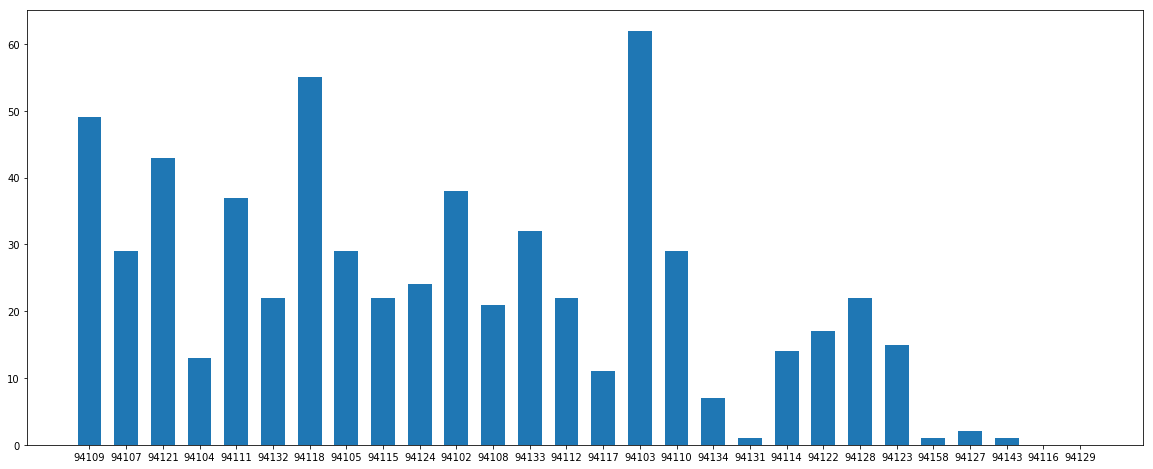

In [6]:
# plot of counts per zipcode for reference
plt.rcParams["figure.figsize"] = [20, 8]
plt.bar(dictionary.keys(), dictionary.values(), width=0.65)

This is the exact breakdown of how we categorized the zipcodes into the 10 districts. 

1. Richmond - 94118, 94121
2. Marina - 94123,94129
3. Nob Hill- 94108,94109,94111,94133
4. Sunset-94116,94122
5. Haight-94117,94115
6. Market -94102,94103,94104,94105
7. Twin Peaks-94127,94131,94132
8. Castro-94114
9. Mission-94107,94110,94158
10. Portola-94112,94124,94134

In order to get the number of reports per district, we added the counts of the reports of each zipcode in that district. We created a new dictionary with the key as the district and the value as the total count of reports in the district. 

In [7]:
# add counts of all zipcodes in each district to get total count of reports of district
district_dict = dict()
district_dict["Richmond"] = dictionary["94118"] + dictionary["94121"] 
district_dict["Marina"] = dictionary["94123"] + dictionary["94129"]
district_dict["Nob Hill"] = dictionary["94108"] + dictionary["94109"] + dictionary["94111"] + dictionary["94133"] 
district_dict["Sunset"] = dictionary["94116"] + dictionary["94122"] 
district_dict["Haight"] = dictionary["94117"] + dictionary["94115"] 
district_dict["Market"] = dictionary["94102"] + dictionary["94103"]+ dictionary["94104"] + dictionary["94105"]
district_dict["Twin Peaks"] = dictionary["94127"] + dictionary["94131"] + dictionary["94132"]
district_dict["Castro"] = dictionary["94114"]
district_dict["Mission"] = dictionary["94107"] + dictionary["94110"] + dictionary["94158"]
district_dict["Portola"] = dictionary["94112"] + dictionary["94124"] + dictionary["94134"]
district_dict

{'Richmond': 98,
 'Marina': 15,
 'Nob Hill': 139,
 'Sunset': 17,
 'Haight': 33,
 'Market': 142,
 'Twin Peaks': 25,
 'Castro': 14,
 'Mission': 59,
 'Portola': 53}

During this analysis so far, we did not account for certain factors that might skew the data such as population. In order to make the data more balanced, we analyzed the percentages of reports per district instead of just a raw count of reports. To do this we summed all the reports of all districts to get a total count and then calculated the percentage of each district using this total. We then added this value back to the dictionary to be analyzed. 

In [8]:
# find total number of reports in San Francisco
total = sum(district_dict.values())

# change dictionary values from raw counts to percentages of total reports
district_dict = {k: ((v * 100)/ total) for k, v in district_dict.items()}

### Results

In order to visualize this data, we decided the best method would be to make a histogram of the percentage of reports of each district. We used the final dictionary computed so the x-axis of the plot was the keys which was the district name, and the y-axis was the values which was the percentage of the total reports from restaurants in each district.

Text(0.5,1,'Percentage of iwaspoisoned.com Reports per District')

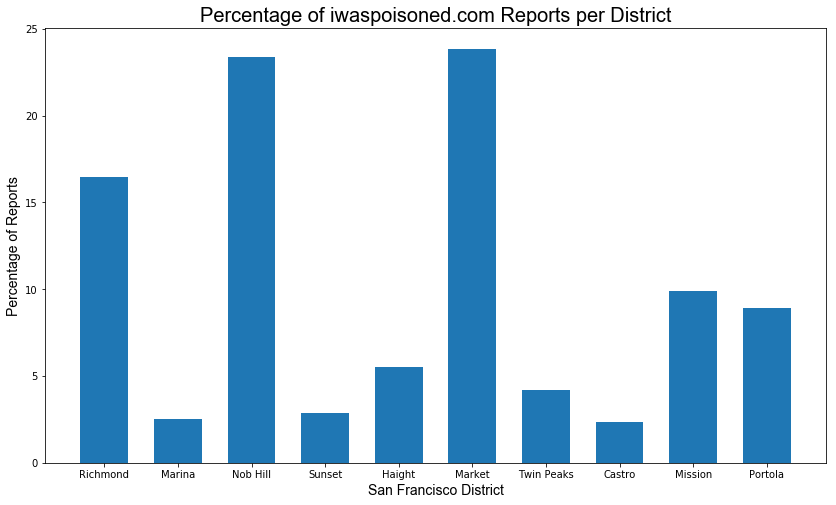

In [9]:
# construct bar plot from dictionary
plt.rcParams["figure.figsize"] = [14, 8]

# x-axis: district name, y-axis: percentage of reports
plt.bar(district_dict.keys(), district_dict.values(), width=0.65)
axis_font = {'fontname':'Arial', 'size':'14'}
title_font = {'fontname':'Arial', 'size':'20'}
plt.ylabel("Percentage of Reports", **axis_font)
plt.xlabel("San Francisco District", **axis_font)
plt.title("Percentage of iwaspoisoned.com Reports per District", **title_font)

### Observations and Comments

The very nature of the website is to report specific unhygienic or negative experiences at restaurants. As a result, it could be argued that the data might be slightly biased or subjective as it is consumer-driven experiences. However, we accounted for the fact that the reports are all negative as we did not analyze the specific content or reason of each report. Instead, we counted the number of negative experiences of restaurants in any area. 

Further, we realized certain areas could have more reports of food poisoning simply for the fact that the area is more populated than others and is more likely to have reports from consumers at its restaurants. In order to account for this, instead of simply comparing the raw counts of reports per district, we analyzed the percentages of reports of the total number of reports in San Francisco. While this may not account for differences population density exactly, it does get rid of some of the possible bias in the data to a certain extent. 

Another way we accounted for certain factors that may affect the data is the manner in which we divided the zipcodes into the 10 districts. We revised this division of districts a couple times as initially, we realized certain districts included upto 5 neighborhoods while other districts just had one or two. As expected, these percentage of these districts were much higher compared to others simply because they encompassed more neighborhoods. We then rearranged the neighborhoods to make the districts more fairly divided so the zipcodes were evenly distributed. 

Once all the factors had been accounted for, we analyzed the data using a histogram. It can be seen that the districts with the highest percentage of the total food poisoning reports were Market and Nob Hill. Both districts together had a combination of around 50% of the total reports. Market was expected to be one of the districts with the most reports as it includes certain lower income neighborhoods such as Tenderloin and Civic Center. However, we were surprised that Nob Hill, a relatively high-end district, had almost as many reports. One reason for this result could be the fact that the Chinatown neighborhood is part of the district and a majority of the reports stemmed from restaurants in this area. 

We can see the districts with the least percentages of reports are Marina, Sunset and Castro districts with a combination of less than 10% of the total reports on the site. This result was expected as these districts are all nicer, more hygienic neighborhoods with more residential areas than offices and other buildings. 

Although this data on its own is not conclusive enough to asses the districts, it highlights the quality of restaurants in each of the districts in terms of health and hygiene which is an important factor when considering quality. 